<a href="https://colab.research.google.com/github/hitesh-pathak/DS_assessment/blob/main/Bike_demand_Model_Building.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [153]:
import pickle
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [110]:
### import pre processed csv from github

df = pd.read_csv('https://github.com/hitesh-pathak/DS_assessment/raw/main/pre_processed_data.csv')

df_cols = df.columns.tolist()
num_cols = df_cols[7:-3]

## need to convert categorical data, as it's saved as object dtype in csv files.
ordinal_col = ['year', 'month', 'weekday']
nominal_col = ['holiday', 'workingday', 'season', 'weather']

cat_cols = ordinal_col + nominal_col

df.loc[:, nominal_col] = df[nominal_col].astype('category')

## order the ordinal categories
cat_year = CategoricalDtype([2018, 2019], ordered=True)
cat_month = CategoricalDtype(['January', 'February', 'March', 'April', 'May',
                          'June', 'July', 'August', 'September', 'October',
                          'November', 'December'], ordered=True)

cat_days = CategoricalDtype(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
                            ordered = True)

df['year'] = df['year'].astype(cat_year)
df['month'] = df['month'].astype(cat_month)
df['weekday'] = df['weekday'].astype(cat_days)

## sort by categories
df.sort_values(by=['year', 'month', 'weekday'])

## remove casual and registered since they are dependent variables.
df = df.drop(['casual', 'registered'], axis = 1)
df.head(7)


,year,month,weekday,holiday,workingday,season,weather,temp,atemp,humidity,windspeed,count
0,2018,January,Monday,0,1,s1,w2,14.110847,18.18125,80.5833,10.749882,985
1,2018,January,Tuesday,0,1,s1,w2,14.902598,17.68695,69.6087,16.652113,801
2,2018,January,Wednesday,0,1,s1,w1,8.050924,9.47025,43.7273,16.636703,1349
3,2018,January,Thursday,0,1,s1,w1,8.200000,10.60610,59.0435,10.739832,1562
4,2018,January,Friday,0,1,s1,w1,9.305237,11.46350,43.6957,12.522300,1600
5,2018,January,Saturday,0,0,s1,w1,8.378268,11.66045,51.8261,6.000868,1606
6,2018,January,Sunday,0,0,s1,w2,8.057402,10.44195,49.8696,11.304642,1510


> I will fit a linear regressor, but before we must convert categorical columns to numerical.

**One hot encoding** ->

In [111]:
cat_cols

['year', 'month', 'weekday', 'holiday', 'workingday', 'season', 'weather']

In [112]:
### get a sparse DF with one-hot encodings

df_oh= pd.get_dummies(df[cat_cols], drop_first=True)
print(df_oh.shape)
df_oh.sample(10)

(730, 25)


,year_2019,month_February,month_March,month_April,month_May,month_June,month_July,month_August,month_September,month_October,...,weekday_Friday,weekday_Saturday,weekday_Sunday,holiday_1,workingday_1,season_s2,season_s3,season_s4,weather_w2,weather_w3
324,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,1
670,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
548,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,1,0,0,0
720,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
609,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,1,0,1,0
76,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
30,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
691,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
268,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,1,1,0


In [113]:
### add one-hot encoded colums and remove the original categorical columns

df_oh = pd.concat ([df_oh, df], axis=1)
df_oh = df_oh.drop(cat_cols, axis=1)

print(df_oh.shape)
df_oh.sample(5)

(730, 30)


,year_2019,month_February,month_March,month_April,month_May,month_June,month_July,month_August,month_September,month_October,...,season_s2,season_s3,season_s4,weather_w2,weather_w3,temp,atemp,humidity,windspeed,count
68,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,15.952731,19.28340,0.0000,17.545759,623
101,0,0,0,1,0,0,0,0,0,0,...,1,0,0,1,0,20.602500,24.65270,73.9167,18.416893,2034
669,1,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,14.999153,18.49710,58.1667,10.542182,5986
351,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,9.771653,12.27895,58.6250,11.375193,2431
485,1,0,0,0,1,0,0,0,0,0,...,1,0,0,1,0,25.146653,28.85105,65.9583,10.458432,5740


> There are 30 columns here, we need to figure out which ones contribute the most.
> To begin I'll use *Recursive Feature Elimination* with a Linear regressor as estimator.

# RFE with Linear Regressor

> The reason I am using a Linear regressor is since RFE is an iterative process, and using something like Random Forest is much more time consuming.

> Another reason is that EDA suggests that dependent variable has linear relationship with some of the dependent variables.

**Splitting dataset**

In [114]:
df_train, df_test = train_test_split(df_oh, test_size=0.20, random_state=1)

print(df_train.shape, df_test.shape)

(584, 30) (146, 30)


**Scaling continuous features**

> We need to scale the non categorical features. But to select the type of scaling we first need to see the distribution of features.

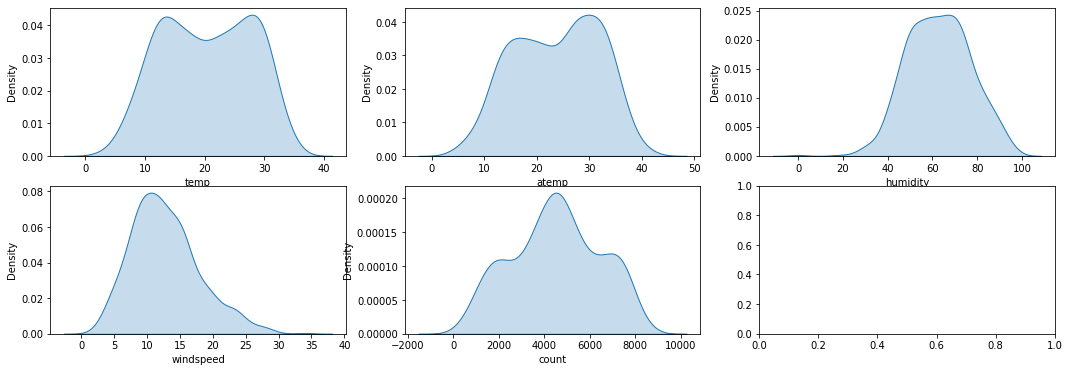

In [115]:
scale_cols = num_cols + ['count']
fig, axes = plt.subplots(2, 3, figsize=(18, 6))
for i, col in enumerate(scale_cols[:3]):
  sns.kdeplot(data=df_oh, x=col, ax=axes[0][i], fill=True)
for i, col in enumerate(scale_cols[3:]):
  sns.kdeplot(data=df_oh, x=col, ax=axes[1][i], fill=True)

> Not all features resemble a normal distribution so I'll just use Minmax scaler to scale them, for normal features we StandardScaler is usually a better choice.

In [116]:
## scale
scaler = MinMaxScaler()
df_train[scale_cols] = scaler.fit_transform(df_train[scale_cols])

df_train[scale_cols].head()   ### scaled

,temp,atemp,humidity,windspeed,count
68,0.411147,0.402452,0.000000,0.493712,0.069144
76,0.599187,0.587981,0.540069,0.430092,0.370110
615,0.747675,0.698389,0.821766,0.533349,0.684998
713,0.330249,0.340384,0.668809,0.173084,0.578118
139,0.595034,0.590650,0.739931,0.211559,0.563162


**Building Models**

In [117]:
## scale test data
df_test[scale_cols] = scaler.transform(df_test[scale_cols])

x_test = df_test.drop(['count'], axis=1)
y_test = df_test['count']

df_test[scale_cols].head()   ### scaled

,temp,atemp,humidity,windspeed,count
248,0.599187,0.572480,0.912038,0.662895,0.309250
298,0.529616,0.516885,0.740789,0.260272,0.445467
159,0.933543,0.890635,0.584404,0.262830,0.447883
660,0.604379,0.592306,0.659812,0.148749,0.856420
511,0.786094,0.738167,0.716795,0.397425,0.755752


In [118]:
x_train = df_train.drop(['count'], axis=1)
y_train = df_train['count']
print(x_train.shape, y_train.shape)

(584, 29) (584,)


In [119]:
## linear regressor

lm = LinearRegression(n_jobs=-1)
_ = lm.fit(x_train, y_train)

print(f"R2 score: {lm.score(x_test, y_test)}")


R2 score: 0.8821566733534321


**RFE**

In [120]:
rfe = RFECV(lm, scoring='r2', cv=20)             # running RFE
rfe = rfe.fit(x_train, y_train)

In [121]:
### features selected by RFE

rfe_df = pd.DataFrame({'features': x_train.columns, 'selected': rfe.support_, 'rank': rfe.ranking_}, )
rfe_df.sort_values('rank', ignore_index=True)

,features,selected,rank
0,year_2019,True,1
1,atemp,True,1
2,temp,True,1
3,weather_w3,True,1
4,weather_w2,True,1
5,season_s4,True,1
6,season_s3,True,1
7,season_s2,True,1
8,holiday_1,True,1
9,humidity,True,1


In [122]:
## drop the unselected columns.

x_train_rfe = x_train[x_train.columns[rfe.support_]]
x_train_rfe.head()

,year_2019,month_March,month_April,month_May,month_June,month_August,month_September,month_October,holiday_1,season_s2,season_s3,season_s4,weather_w2,weather_w3,temp,atemp,humidity,windspeed
68,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0.411147,0.402452,0.000000,0.493712
76,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0.599187,0.587981,0.540069,0.430092
615,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0.747675,0.698389,0.821766,0.533349
713,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0.330249,0.340384,0.668809,0.173084
139,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0.595034,0.590650,0.739931,0.211559


In [123]:
## also choose the columns for test data
x_test_rfe = x_test[x_test.columns[rfe.support_]]

> So we get 18 selected features with RFE. Now we will do Manual feature selection.

**Manual selection**

> For this I'll use the statmodels package's implementation of linear regressor, since it is easy to print summary statistics with statmodels.

In [124]:
### print summary statistics for linear regressor

def fit_ols(x=x_train_rfe, y=y_train):
    # add intercept
    print(x.columns)
    x_sm = sm.add_constant(x)

    # fit ordinary least squares
    lm = sm.OLS(y, x_sm).fit()

    # print stats
    print(lm.summary())
    return lm

> Along with the stats from model

> I will use **Variable Inflation Factor VIF** to check for *multicollinearity*.



In [125]:
### print vif

def print_vif(df=x_train_rfe):
  df_vif = pd.DataFrame()
  df_vif['Features'] = df.columns
  df_vif['VIF'] = [round(variance_inflation_factor(df.values, k), 2)
                  for k in range(df.shape[1])]

  print(df_vif.sort_values(by='VIF',ascending=False))

In [126]:
def drop_cols(cols, df=x_train_rfe):
  return df.drop(cols, axis=1)

> Now we can start, we will train the ols model and then look at vif of columns to find the ones that may be removed.

In [127]:
fit_ols()
print_vif()

Index(['year_2019', 'month_March', 'month_April', 'month_May', 'month_June',
       'month_August', 'month_September', 'month_October', 'holiday_1',
       'season_s2', 'season_s3', 'season_s4', 'weather_w2', 'weather_w3',
       'temp', 'atemp', 'humidity', 'windspeed'],
      dtype='object')
                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     152.8
Date:                Sun, 31 Jul 2022   Prob (F-statistic):          2.09e-203
Time:                        16:01:41   Log-Likelihood:                 573.62
No. Observations:                 584   AIC:                            -1109.
Df Residuals:                     565   BIC:                            -1026.
Df Model:                          18                                    

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


> Temp and atemp are highly correlated, and so only one of them should be kept.
> Atemp has hight P-value, so it is not significant to out model.

> So we drop Atemp and repeat the process.

In [128]:
x_new = drop_cols(['atemp'])
fit_ols(x_new)
print_vif(x_new)

Index(['year_2019', 'month_March', 'month_April', 'month_May', 'month_June',
       'month_August', 'month_September', 'month_October', 'holiday_1',
       'season_s2', 'season_s3', 'season_s4', 'weather_w2', 'weather_w3',
       'temp', 'humidity', 'windspeed'],
      dtype='object')
                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     161.9
Date:                Sun, 31 Jul 2022   Prob (F-statistic):          2.08e-204
Time:                        16:01:41   Log-Likelihood:                 573.35
No. Observations:                 584   AIC:                            -1111.
Df Residuals:                     566   BIC:                            -1032.
Df Model:                          17                                         
Cov

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


           Features    VIF
14             temp  29.02
15         humidity  16.52
9         season_s2   9.00
10        season_s3   8.76
16        windspeed   4.55
3         month_May   4.01
2       month_April   3.82
11        season_s4   3.19
4        month_June   2.84
12       weather_w2   2.15
0         year_2019   1.97
5      month_August   1.74
1       month_March   1.65
7     month_October   1.59
6   month_September   1.50
13       weather_w3   1.20
8         holiday_1   1.05


> The warnings shown are due to statmodels package only, but it works as expected so we can ignore them.


> Removing month_April because of high p-value.
\
> Also from vif chart, it looks like temp and humidity might be correlated.

In [129]:
x_new = drop_cols(['month_April'], x_new)
fit_ols(x_new)
print_vif(x_new)

Index(['year_2019', 'month_March', 'month_May', 'month_June', 'month_August',
       'month_September', 'month_October', 'holiday_1', 'season_s2',
       'season_s3', 'season_s4', 'weather_w2', 'weather_w3', 'temp',
       'humidity', 'windspeed'],
      dtype='object')
                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     171.3
Date:                Sun, 31 Jul 2022   Prob (F-statistic):          5.82e-205
Time:                        16:01:41   Log-Likelihood:                 571.99
No. Observations:                 584   AIC:                            -1110.
Df Residuals:                     567   BIC:                            -1036.
Df Model:                          16                                         
Covariance Type:  

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


> Removing month_June because of high p-value.

In [130]:
x_new = drop_cols(['month_June'], x_new)
fit_ols(x_new)
print_vif(x_new)

Index(['year_2019', 'month_March', 'month_May', 'month_August',
       'month_September', 'month_October', 'holiday_1', 'season_s2',
       'season_s3', 'season_s4', 'weather_w2', 'weather_w3', 'temp',
       'humidity', 'windspeed'],
      dtype='object')


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     182.3
Date:                Sun, 31 Jul 2022   Prob (F-statistic):          1.11e-205
Time:                        16:01:41   Log-Likelihood:                 570.99
No. Observations:                 584   AIC:                            -1110.
Df Residuals:                     568   BIC:                            -1040.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.2519      0.028     

> Removing month_August because of high p-value.\
> We want **p_value < 0.05** (significance interval of 5%)

In [131]:
x_new = drop_cols(['month_August'], x_new)
fit_ols(x_new)
print_vif(x_new)

Index(['year_2019', 'month_March', 'month_May', 'month_September',
       'month_October', 'holiday_1', 'season_s2', 'season_s3', 'season_s4',
       'weather_w2', 'weather_w3', 'temp', 'humidity', 'windspeed'],
      dtype='object')


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     194.4
Date:                Sun, 31 Jul 2022   Prob (F-statistic):          3.86e-206
Time:                        16:01:41   Log-Likelihood:                 569.34
No. Observations:                 584   AIC:                            -1109.
Df Residuals:                     569   BIC:                            -1043.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.2490      0.028     

> From EDA we know temp has a linear relationship with count, so we will choose to remove Humidity because of hight p-vale.\
> Also from EDA Humidity did not have any clear relationship with count.

In [132]:
x_new = drop_cols(['humidity'], x_new)
fit_ols(x_new)
print_vif(x_new)

Index(['year_2019', 'month_March', 'month_May', 'month_September',
       'month_October', 'holiday_1', 'season_s2', 'season_s3', 'season_s4',
       'weather_w2', 'weather_w3', 'temp', 'windspeed'],
      dtype='object')
                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     198.4
Date:                Sun, 31 Jul 2022   Prob (F-statistic):          1.08e-201
Time:                        16:01:41   Log-Likelihood:                 556.04
No. Observations:                 584   AIC:                            -1084.
Df Residuals:                     570   BIC:                            -1023.
Df Model:                          13                                         
Covariance Type:            nonrobust                              

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)



           Features    VIF
11             temp  16.58
7         season_s3   7.30
6         season_s2   4.06
12        windspeed   3.92
8         season_s4   2.88
0         year_2019   1.96
2         month_May   1.61
4     month_October   1.55
9        weather_w2   1.45
3   month_September   1.28
1       month_March   1.24
10       weather_w3   1.08
5         holiday_1   1.04


> Removing month_May because of high p-value

In [133]:
x_new = drop_cols(['month_May'], x_new)
fit_ols(x_new)
print_vif(x_new)

Index(['year_2019', 'month_March', 'month_September', 'month_October',
       'holiday_1', 'season_s2', 'season_s3', 'season_s4', 'weather_w2',
       'weather_w3', 'temp', 'windspeed'],
      dtype='object')
                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     214.4
Date:                Sun, 31 Jul 2022   Prob (F-statistic):          1.87e-202
Time:                        16:01:42   Log-Likelihood:                 555.06
No. Observations:                 584   AIC:                            -1084.
Df Residuals:                     571   BIC:                            -1027.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
 

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


> season_s2 and season_s3 have high vif. These are the seasons 'summer' and 'fall', and from EDA we know that they have similar count values.
> we will drop season_s3.

> Here I've defined a new column which is 1 if it's either Summer or Fall and 0 otherwise.\
> And I'll drop both season_s2 and season_s3 in favor of this column.

In [134]:
s = (x_new['season_s2'] == 1) | (x_new['season_s3'] == 1)
x_new1 = x_new.copy()
x_new1['s2_or_s3'] = s.astype('uint8')

In [135]:
x_new1 = drop_cols(['season_s3', 'season_s2'], x_new1)
fit_ols(x_new1)
print_vif(x_new1)

Index(['year_2019', 'month_March', 'month_September', 'month_October',
       'holiday_1', 'season_s4', 'weather_w2', 'weather_w3', 'temp',
       'windspeed', 's2_or_s3'],
      dtype='object')
                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.810
Method:                 Least Squares   F-statistic:                     226.7
Date:                Sun, 31 Jul 2022   Prob (F-statistic):          2.64e-200
Time:                        16:01:42   Log-Likelihood:                 547.17
No. Observations:                 584   AIC:                            -1070.
Df Residuals:                     572   BIC:                            -1018.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
               

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


> This suggests that there is hight correlation between Summer and Fall Temperature which is intuitive.
> So I'll drop Summer or season_s3 column as that has higher correlation to temp.

In [136]:
x_new = drop_cols(['season_s3'], x_new)
model = fit_ols(x_new)
print_vif(x_new)

Index(['year_2019', 'month_March', 'month_September', 'month_October',
       'holiday_1', 'season_s2', 'season_s4', 'weather_w2', 'weather_w3',
       'temp', 'windspeed'],
      dtype='object')
                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.808
Method:                 Least Squares   F-statistic:                     224.7
Date:                Sun, 31 Jul 2022   Prob (F-statistic):          2.07e-199
Time:                        16:01:42   Log-Likelihood:                 545.06
No. Observations:                 584   AIC:                            -1066.
Df Residuals:                     572   BIC:                            -1014.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
              

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


> All p-values < 0.05 and VIF < 5. The model seems to be good now.\


# Feature importance from linear regression

In [137]:
## extract model summary as dataframe
summ1_df = pd.read_html(model.summary().tables[0].as_html(),header=0,index_col=0)[0]
summ1_df



,count,R-squared:,0.812
Dep. Variable:,,,
Model:,OLS,Adj. R-squared:,8.080000e-01
Method:,Least Squares,F-statistic:,2.247000e+02
Date:,"Sun, 31 Jul 2022",Prob (F-statistic):,2.070000e-199
Time:,16:01:42,Log-Likelihood:,5.450600e+02
No. Observations:,584,AIC:,-1.066000e+03
Df Residuals:,572,BIC:,-1.014000e+03
Df Model:,11,NaN,NaN
Covariance Type:,nonrobust,NaN,NaN


In [138]:
summ2_df = pd.read_html(model.summary().tables[1].as_html(),header=0,index_col=0)[0]
summ2_df

,coef,std err,t,P>|t|,[0.025,0.975]
const,0.1209,0.018,6.871,0.000,0.086,0.155
year_2019,0.2357,0.008,29.507,0.000,0.220,0.251
month_March,0.0340,0.016,2.188,0.029,0.003,0.065
month_September,0.1080,0.015,7.108,0.000,0.078,0.138
month_October,0.0509,0.018,2.888,0.004,0.016,0.085
holiday_1,-0.0891,0.023,-3.852,0.000,-0.135,-0.044
season_s2,0.0937,0.010,9.462,0.000,0.074,0.113
season_s4,0.1133,0.012,9.391,0.000,0.090,0.137
weather_w2,-0.0700,0.009,-8.101,0.000,-0.087,-0.053
weather_w3,-0.2787,0.024,-11.502,0.000,-0.326,-0.231


- I've obtained a decent model where VIF < 5 which means there is low collinearlity between the independent variables as should be the case.
- The p-values of all features is significantly low (< 0.03) which suggests that all the features contribute significantly.
- The F-statistic ~225 and p-value ~ 0 of the overall model.
- R2 score and Adj R2 scores are not too far apart, which also suggests that all features are relevant.

**Ranked list of features**

In [139]:
rank_features = summ2_df[['coef']].abs().sort_values('coef', ascending=False).reset_index()
rank_features = rank_features[rank_features['index'] != 'const']
rank_features = rank_features.rename(columns={'index': 'features', 'coef': 'weights'}).reset_index().drop('index', axis=1)
rank_features

,features,weights
0,temp,0.5415
1,weather_w3,0.2787
2,year_2019,0.2357
3,windspeed,0.1477
4,season_s4,0.1133
5,month_September,0.1080
6,season_s2,0.0937
7,holiday_1,0.0891
8,weather_w2,0.0700
9,month_October,0.0509


In [140]:
x_train_new = x_train_rfe[rank_features['features']]
x_test_new = x_test_rfe[rank_features['features']]

# Model Evaluation

> Now at last I'll train a model with Hyper-parameter tuning, with the selected columns. The final metric and predictions will be derived from this model

> Hyper parameter tuning

In [141]:
n_estimators = [int(x) for x in np.arange(100, 1000, 100)]
max_depth = [int(x) for x in np.arange(10, 210, 10)] + [None]
max_features = ['auto', 'sqrt']
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

rf_params= {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

for x in rf_params:
  print(x, rf_params[x])


n_estimators [100, 200, 300, 400, 500, 600, 700, 800, 900]
max_features ['auto', 'sqrt']
max_depth [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, None]
min_samples_split [2, 5, 10]
min_samples_leaf [1, 2, 4]
bootstrap [True, False]


In [147]:
## random search

rf = RandomForestRegressor()

random_cv = RandomizedSearchCV(estimator = rf, param_distributions = rf_params,
                               n_iter = 200, cv = 3, verbose=5, random_state=11,
                               n_jobs = -1, scoring='r2')

# Fit rf
random_cv.fit(x_train_new, y_train)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=200,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110, 120,
                                                      130, 140, 150, 160, 170,
                                                      180, 190, 200, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900]},
                   random_state=11, scoring='r2', verbose=5)

In [149]:
random_cv.best_params_


{'bootstrap': True,
 'max_depth': 130,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 400}

In [154]:
## save model for later use
best_rf = random_cv.best_estimator_

filename = './final_model.sav'
with open(filename, 'wb') as f:
  pickle.dump(best_rf, f)

**Save models**

In [ ]:
from google.colab import files
files.download(filename)   ## only for download from colab

**Evaluation with R2 and adj. R2 metric**

In [156]:
def evaluate(model, x_test, y_test):
  pred = model.predict(x_test)
  r2 = r2_score(y_test, pred)

  n = x_test.shape[0]
  p = x_test.shape[1]

  adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)

  return r2, adjusted_r2


In [159]:
## load model from github so don't have to train all the time
import urllib.request

final_model = pickle.load(urllib.request.urlopen(
    'https://github.com/hitesh-pathak/DS_assessment/blob/main/final_model.sav?raw=true'))

print(final_model)

RandomForestRegressor(max_depth=130, max_features='sqrt', min_samples_split=5,
                      n_estimators=400)


In [160]:
## base model for comparison

base_model = RandomForestRegressor(n_estimators=10, random_state = 1)
base_model.fit(x_train_new, y_train)
r2, ar2 = evaluate(base_model, x_test_new, y_test)
print(f'R2 score: {r2}')

print(f'Adjusted R2 score: {ar2}')

R2 score: 0.8652241710759572
Adjusted R2 score: 0.8541604836269686


In [161]:
### our model

r2, ar2 = evaluate(final_model, x_test_new, y_test)
print(f'R2 score: {r2}')
print(f'Adjusted R2 score: {ar2}')

R2 score: 0.8841544808113475
Adjusted R2 score: 0.874644774012279


# Residue analysis

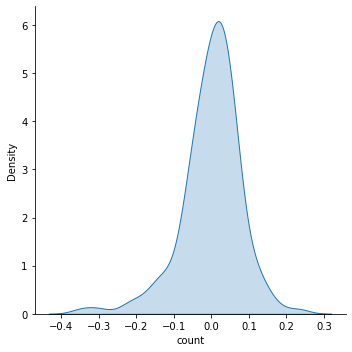

In [164]:
y_pred = final_model.predict(x_test_new)
sns.displot(x=y_test-y_pred, kind='kde', fill=True)

> Residual are normally distributed with 0 mean, indicating there is no constant systematic error.

In [173]:
## dataframe with predictions and actual values

result_df = pd.DataFrame({'predicted': y_pred, 'actual': y_test})
result_df['abs_error'] = (result_df['actual'] - result_df['predicted']).abs()
result_df.head()

,predicted,actual,abs_error
248,0.296996,0.309250,0.012254
298,0.490437,0.445467,0.044970
159,0.495199,0.447883,0.047316
660,0.840880,0.856420,0.015539
511,0.781092,0.755752,0.025339


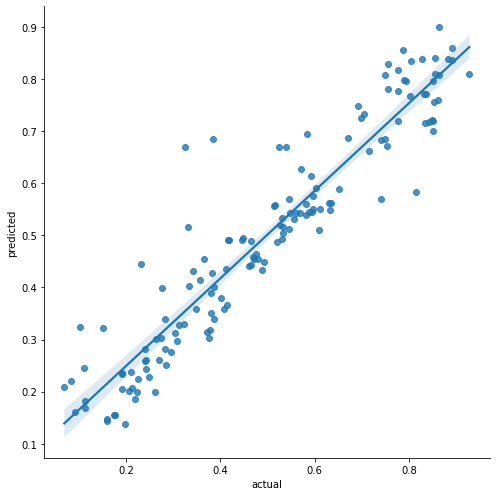

In [176]:
sns.lmplot(data=result_df, x='actual',y = 'predicted', height=7, aspect=1)

> Predictions vary linearly as the actual values, there is a direct propotionality with positive slope.

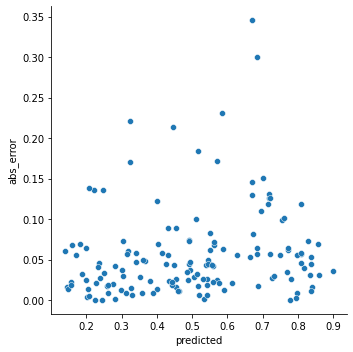

In [178]:
sns.relplot(data=result_df, x='predicted', y='abs_error')

> Residues do not depend on predicted values

# Final feature importance form random forest model

In [184]:
importances = final_model.feature_importances_
feature_importance = pd.DataFrame({'features':x_train_new.columns,
                                  'importance':importances}).sort_values('importance',
                                                                        ascending=False)
feature_importance

,features,importance
0,temp,0.446879
2,year_2019,0.281152
3,windspeed,0.102885
1,weather_w3,0.044100
4,season_s4,0.037112
8,weather_w2,0.024291
5,month_September,0.018348
6,season_s2,0.017071
10,month_March,0.010423
9,month_October,0.009273


# Result

**Metrics**

In [183]:
mean_squared_error(y_test, y_pred, squared=False) ## rmse

0.07951848166585603

**R2 metric or coefficient of determination**: 0.884\
**Adjusted R2 score**: 0.875\
**RMSE**: 0.079 (~ 8%)

**NOTE**: We can either talk about bike-demand at current time (over a short span of months maybe) or bike-demand over a span of years

**Top 3 variables**: considering bike demand over a **short span of time**, *Current Demand* ->
- I'll list these first as these are the ones people would be most interested in

1.  **temp**: Temprature, demand increases as the environment is warmer.
2. **windspeed**: Negative linear relationsip with demand, as the windspeed increases demand goes down
3. **weather_w3**: In Rainy weather the demand drops drastically.


**Top 3 variables**: considering bike demand over a **span of years**, *Overall demand* ->

1. **temp**: Temprature demand increases as the environment is warmer.
2. **year_2019**: This represents that the demand is increasing with time.
3. **windspeed**: Negative linear relationsip with demand, as the windspeed increases demand goes down



**Other impactful variables ranked by decreasing importance**:
5. season_4: Is the currentseason is winter demand goes down during winter.
6. weather_2: Is the weather sligtly cloudy?
7. month_September: Demand increases around september.
8. season_s2: Is this summer season? Demand increases in summers.
9. month_March: Demand is low around March
10. month_October: After October demand decreaes too.
11. holiday: Demand is high on non-holidays.